In [21]:
# Imports

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
import os
import shutil
import gpt
from PIL import Image
import cv2
import threading

import fitz


In [22]:
# Open Image

DIRECTORY = "../images/"
IMAGE_NAME = "class_notes.pdf"
document_path = DIRECTORY + IMAGE_NAME

In [23]:
if ".pdf" in IMAGE_NAME:
    pdffile = document_path
    doc = fitz.open(pdffile)
    page = doc.load_page(0)  # Load first page

    # Define the scaling factor (e.g., 2 for doubling the resolution)
    zoom = 3

    # Create a transformation matrix for scaling
    matrix = fitz.Matrix(zoom, zoom)

    # Get the pixmap with the specified matrix
    pix = page.get_pixmap(matrix=matrix)

    # Save the pixmap as a PNG file
    document_path = '../images/' + IMAGE_NAME[:-4] + '.png'
    pix.save(document_path)

    doc.close()

IMAGE_PATH = document_path


In [24]:
image = Image.open(IMAGE_PATH).convert('RGB')

In [25]:
# Process Image

# Convert PIL Image to OpenCV format
img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Inprove Contrast
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# remove remaining spots
denoised = cv2.medianBlur(thresh, 3)
denoised = cv2.GaussianBlur(denoised, (3, 3), 0)

# Convert back to RGB (but still grayscale)
denoised_3channel = cv2.cvtColor(denoised, cv2.COLOR_GRAY2BGR)
denoised_rgb = cv2.cvtColor(denoised_3channel, cv2.COLOR_BGR2RGB)

# Convert back to PIL Image and then to numpy array
processed_pil = Image.fromarray(denoised_rgb)
img_arr = np.array(processed_pil, dtype=np.uint32)
original_img_arr = np.array(processed_pil, dtype=np.uint8)

Text(0.5, 1.0, 'Original Image')

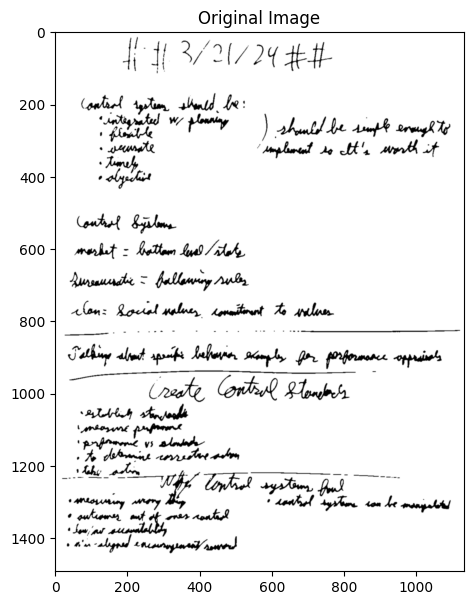

In [26]:
plt.figure(figsize=(15, 7))  # Adjust figure size as needed

#Show Images
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.imshow(np.array(original_img_arr))
#plt.axis('off')
plt.title("Original Image")

In [27]:
def process_image(img_arr):
    '''
    Detect colums in text, then split into segments where best fit
    '''

    # Calculate column brightness
    _, width, _ = img_arr.shape
    column_brightness = []
    
    # Calculate average brightness for each column
    for col_idx in range(width):
        col = img_arr[:, col_idx] # find the colums
        R = np.mean(col[:, 0]) # Avg the the R (0) value in every row of the column
        G = np.mean(col[:, 1])
        B = np.mean(col[:, 2])
        avg = (R + G + B) / 3
        column_brightness.append(avg)
    
    # Find column splits
    column_brightness_np = np.array(column_brightness)
    smoothed_column_data = gaussian_filter1d(column_brightness_np, sigma=30)
    column_peaks, _ = find_peaks(smoothed_column_data,
        distance=100,
        prominence=32
    )
    
    # Split column into sections
    split_images = []
    column_sections = []
    start_col = 0
    all_row_peaks = [] #All peaks in brightness
    
    # Keep track of every place to split into columns
    all_column_splits = np.sort(np.append(column_peaks, width))
    
    # First split into columns
    for end_col in all_column_splits:
        column_section = img_arr[:, start_col:end_col]
        column_sections.append(column_section)
        start_col = end_col
    
    # Process EACH column section for rows
    for col_section in column_sections:
        # Calculate row brightness
        row_brightness = []
        for row in col_section:
            avg = np.mean(row)
            row_brightness.append(avg)
        
        # Find row splits
        row_brightness_np = np.array(row_brightness)
        smoothed_row_data = gaussian_filter1d(row_brightness_np, sigma=5)
        row_peaks, _ = find_peaks(smoothed_row_data,
            distance=200,
            prominence=32
        )
        all_row_peaks.append(row_peaks)
        
        # Split this column into rows
        start_row = 0
        
        # Add row peaks and the last row index
        all_row_splits = np.sort(np.append(row_peaks, col_section.shape[0]))
        
        # Process each row section
        for i, end_row in enumerate(all_row_splits):
            section = col_section[start_row:end_row]
            split_images.append(np.array(section).astype(np.uint8))
            start_row = end_row
    
    # Visualize the splits
    lined_img_arr = img_arr.copy()
    
    # vertical lines for column splits
    for col in column_peaks:
        lined_img_arr[:, col] = [0, 0, 255]
    
    # Add horizontal lines for row splits in each column section
    start_col = 0
    for i, end_col in enumerate(all_column_splits):
        row_peaks = all_row_peaks[i]
        # horizontal lines for this column section
        for row in row_peaks:
            lined_img_arr[row, start_col:end_col] = [255, 0, 0]
        start_col = end_col
    

    # Create figure
    fig, axs = plt.subplots(3, 1, figsize=(15, 20), gridspec_kw={'height_ratios': [1, 1, 2]})

    # column analysis
    axs[0].plot(smoothed_column_data, label="Smoothed Column Brightness")
    axs[0].plot(column_peaks, smoothed_column_data[column_peaks], "x", label="Column Splits")
    axs[0].set_xlabel("Pixel Column Index")
    axs[0].set_ylabel("Brightness")
    axs[0].legend()

    # Row analysis
    axs[1].plot(smoothed_row_data, label="Smoothed Row Brightness")
    axs[1].plot(row_peaks, smoothed_row_data[row_peaks], "x", label="Row Splits")
    axs[1].set_xlabel("Pixel Row Index")
    axs[1].set_ylabel("Brightness")
    axs[1].legend()

    # Result Splits
    axs[2].imshow(lined_img_arr)
    axs[2].set_title("Split Visualization (Blue: Columns, Red: Rows)")

    # Adjust layout to fit 100% horizontally
    plt.tight_layout()
    plt.show()

    
    return split_images

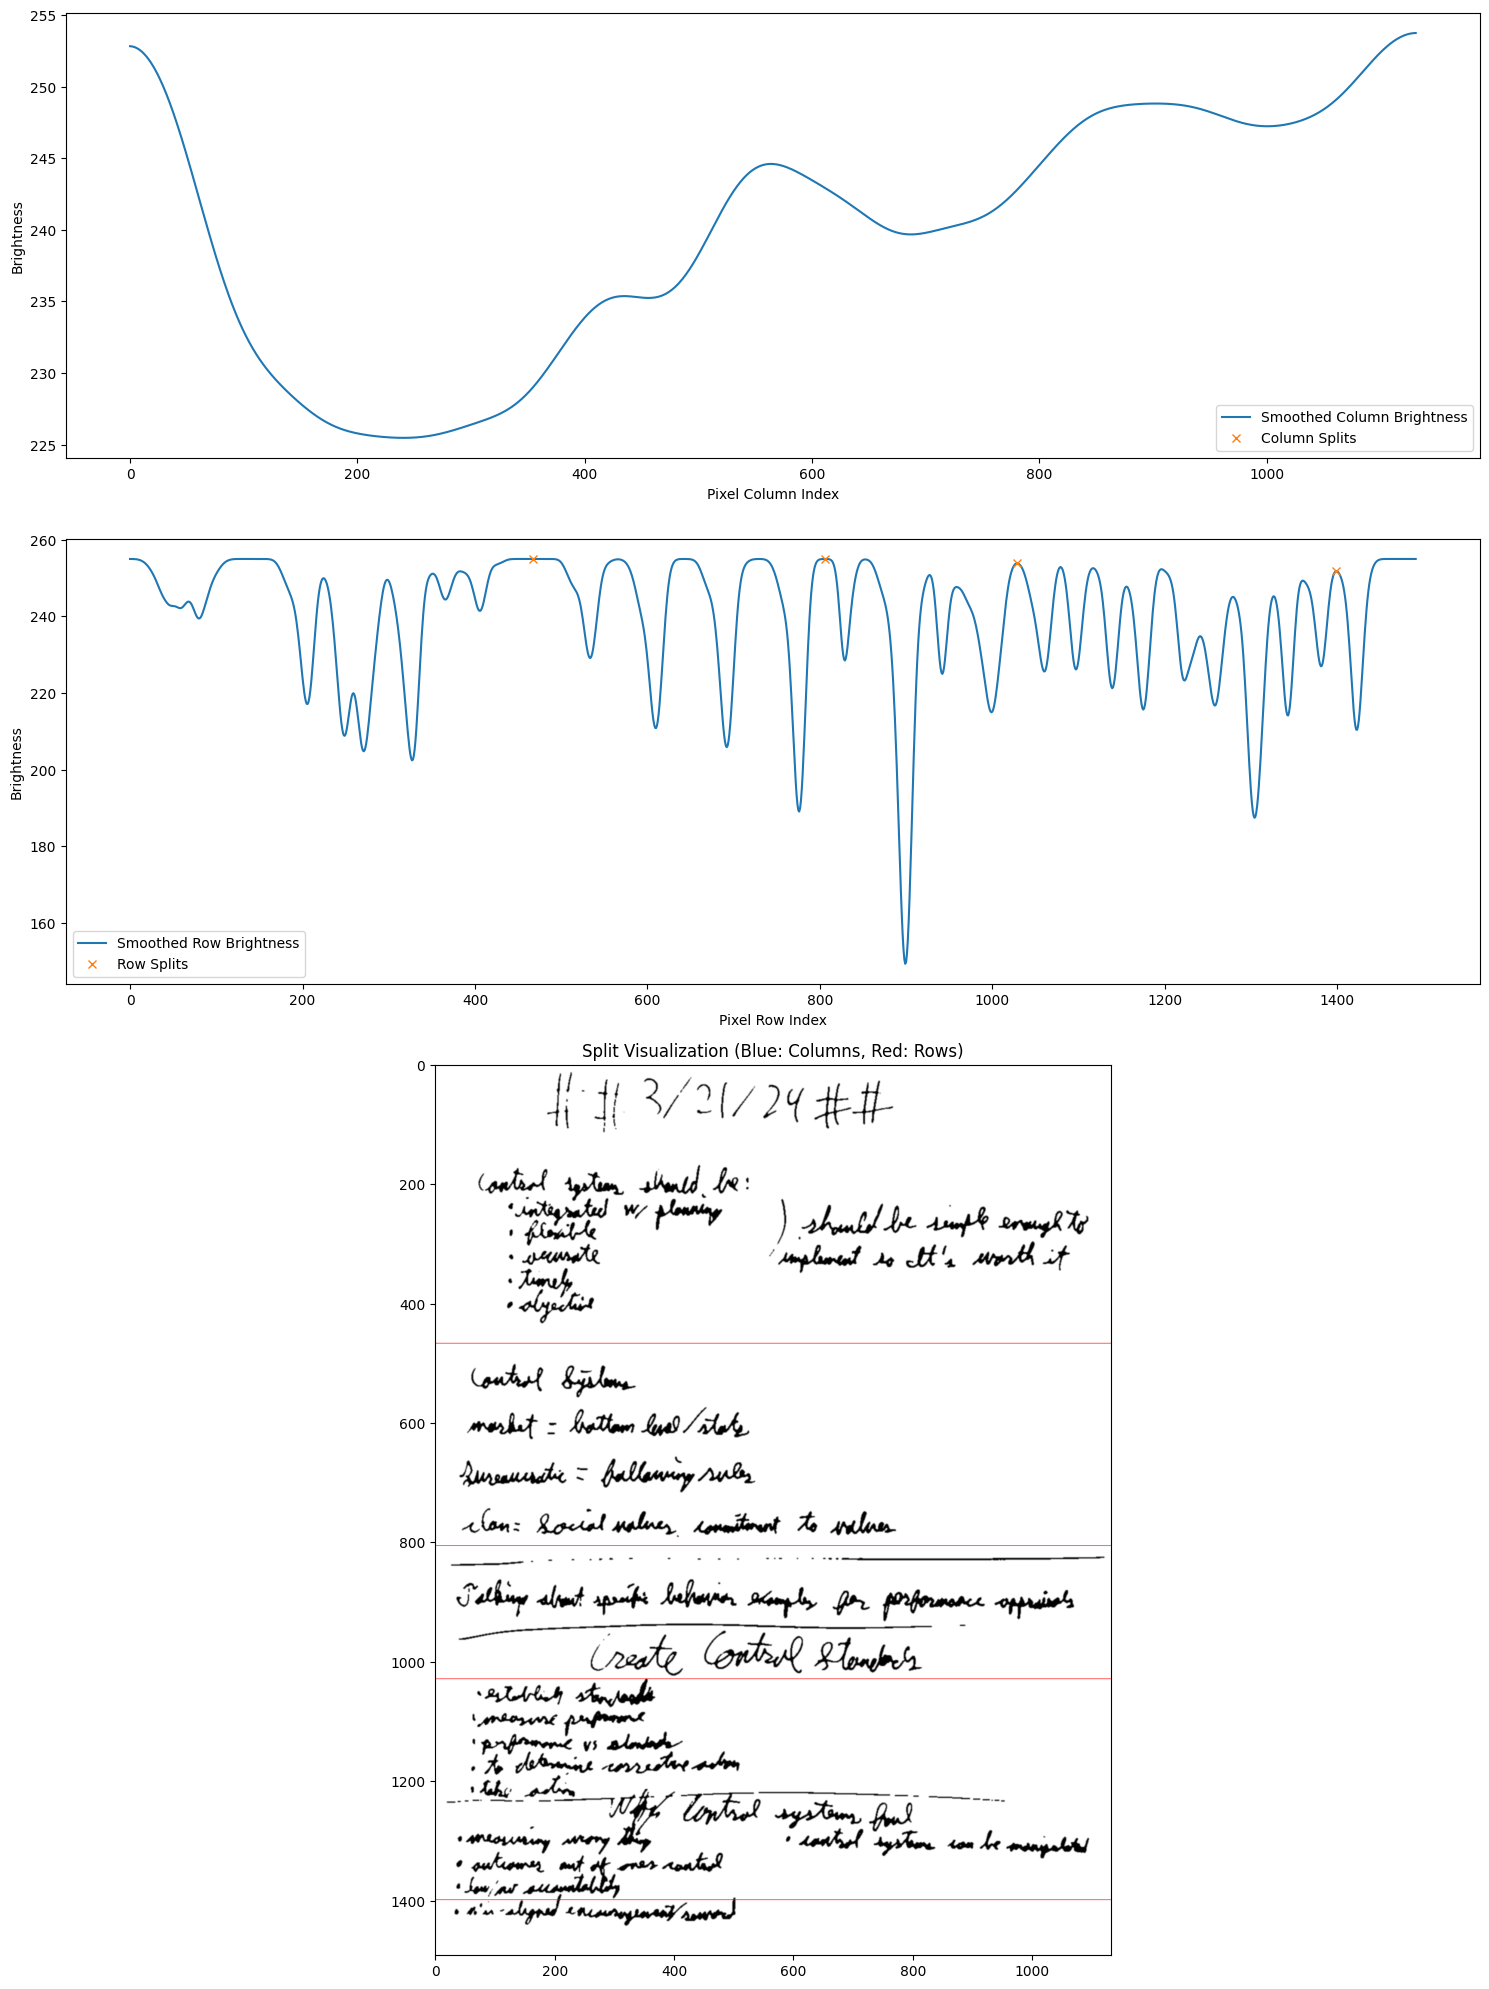

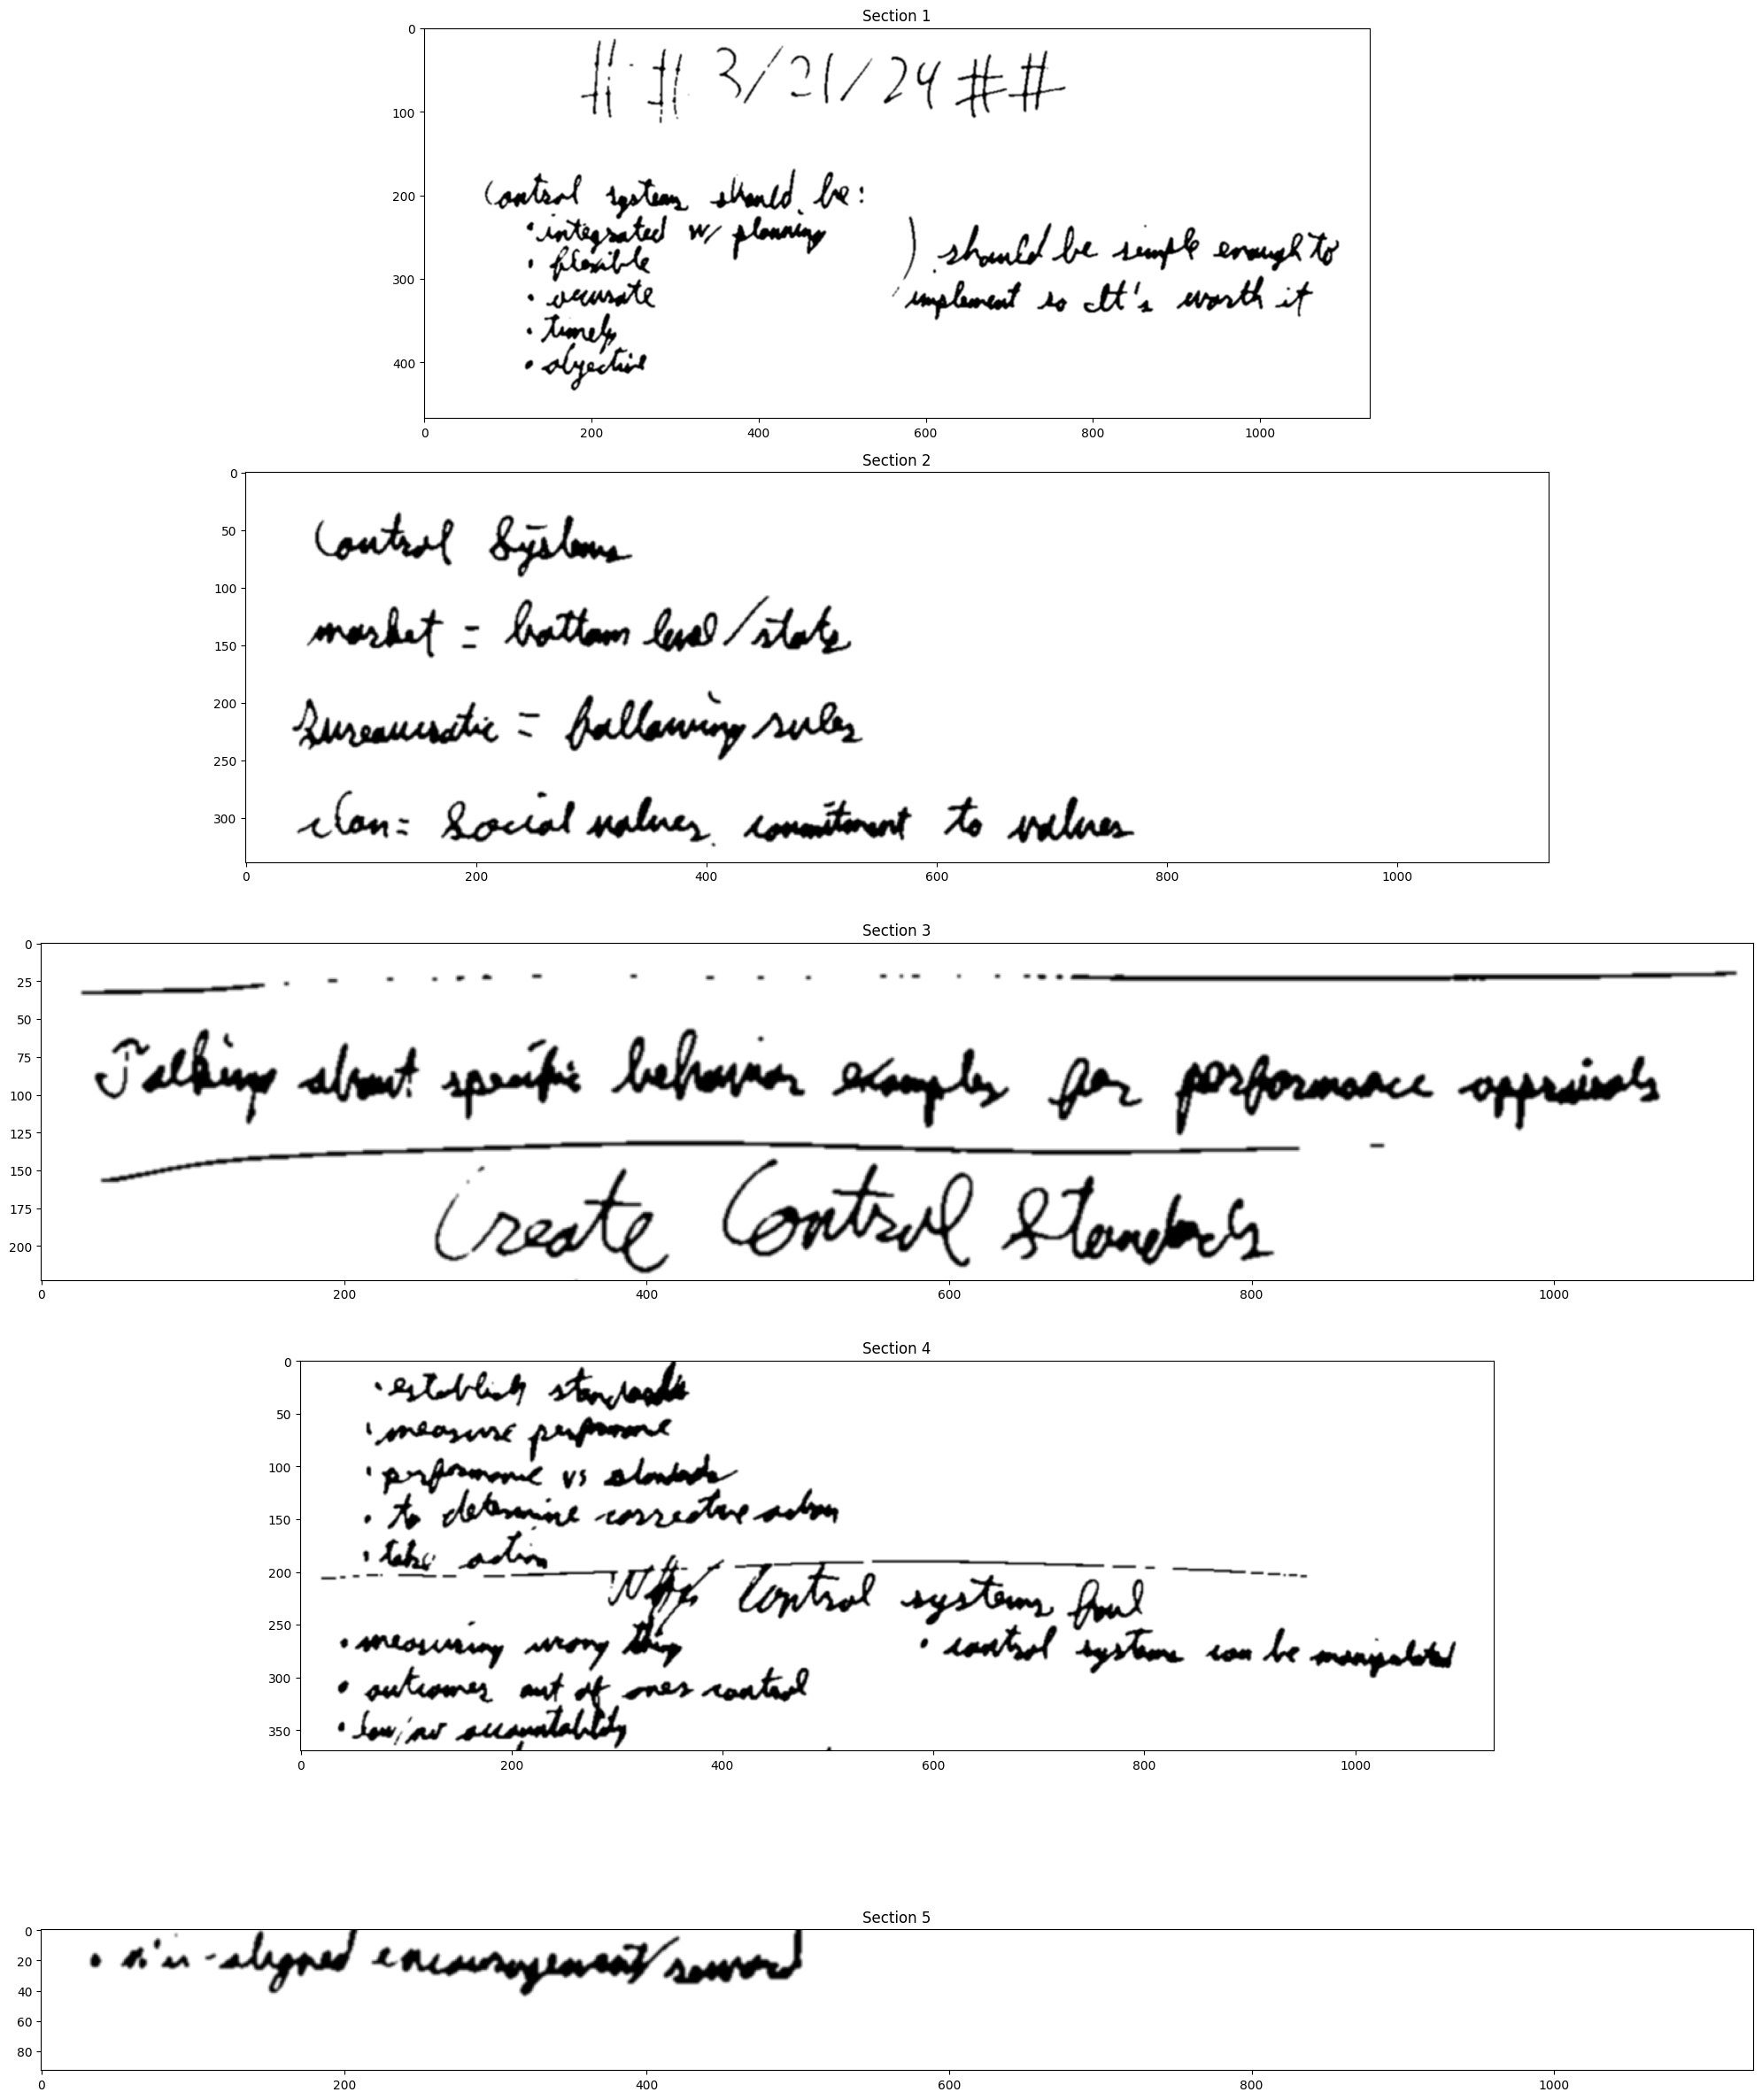

In [28]:
# Process the image
split_images = process_image(original_img_arr)

# Display all sections in a grid
num_sections = len(split_images)
num_cols = 1
num_rows = (num_sections + num_cols - 1) // num_cols

plt.figure(figsize=(20, 5 * num_rows))
for i, section in enumerate(split_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(section)
    plt.title(f"Section {i+1}")
plt.tight_layout()
plt.show()

Processing Image 0
Processing Image 1
Processing Image 2
Processing Image 3
Processing Image 4


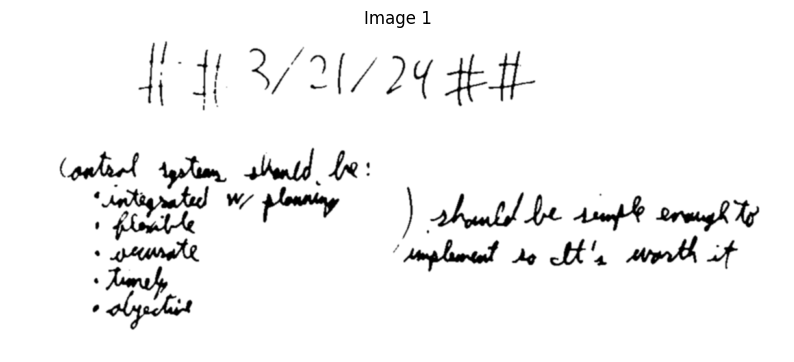

[T1-L1-W1] H i  85%  
[T1-L2-W1] # #  90%  
[T2-L1-W1] 3 / 2 1 / 2 4  92%  
[T2-L2-W1] # #  90%  

[B-L1-W1] C o n t r o l  88%  
[B-L1-W2] s y s t e m  85%  
[B-L1-W3] s h o u l d  90%  
[B-L1-W4] b e  92%  
[B-L1-W5] : 100%  
[B-L2-W1] i n t e g r a t e d  87%  
[B-L2-W2] w /  90%  
[B-L2-W3] p l a n n i n g  85%  
[B-L3-W1] f l e x i b l e  88%  
[B-L4-W1] a c c u r a t e  87%  
[B-L5-W1] t i m e l y  92%  
[B-L6-W1] o b j e c t i v e  85%  
[B-L7-W1] 1 )  90%  
[B-L7-W2] s h o u l d  85%  
[B-L7-W3] b e  88%  
[B-L7-W4] s i m p l e  90%  
[B-L8-W1] e n o u g h  88%  
[B-L8-W2] t o  92%  
[B-L8-W3] i m p l e m e n t  85%  
[B-L8-W4] s o  90%  
[B-L8-W5] i t ' s  92%  
[B-L8-W6] w o r t h  85%  
[B-L8-W7] i t  88%


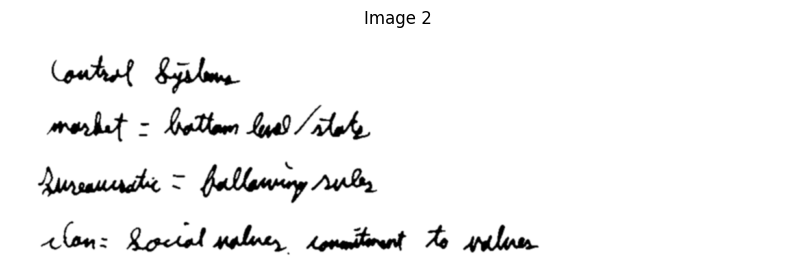

[T1-L1-W1] C o n t r o l  88%  
[T1-L1-W2] S y s t e m s  85%  
[B-L1-W1] m a r k e t  90%  
[B-L1-W2] =  95%  
[B-L1-W3] b o t t o m  92%  
[B-L1-W4] l e v e l / s t a k e  80%  
[B-L2-W1] B u r e a u c r a t i c  85%  
[B-L2-W2] =  95%  
[B-L2-W3] f o l l o w i n g  91%  
[B-L2-W4] r u l e s  90%  
[B-L3-W1] c l a n :  88%  
[B-L3-W2] S o c i a l  90%  
[B-L3-W3] v a l u e s ,  85%  
[B-L3-W4] c o m m i t m e n t  85%  
[B-L3-W5] t o  95%  
[B-L3-W6] v a l u e s  88%  


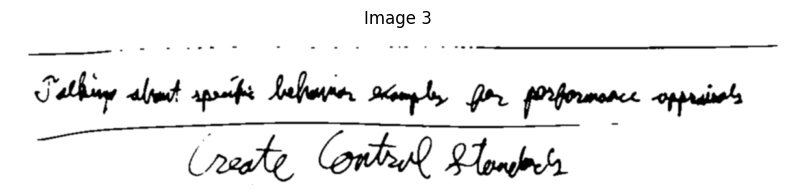

[B-L1-W1] T a l k i n g  85%  
[B-L1-W2] a b o u t  88%  
[B-L1-W3] s p e c i f i c  80%  
[B-L1-W4] b e h a v i o r  82%  
[B-L1-W5] e x a m p l e s  84%  
[B-L1-W6] f o r  89%  
[B-L1-W7] p e r f o r m a n c e  80%  
[B-L1-W8] a p p r a i s a l s  75%  
[B-L2-W1] C r e a t e  90%  
[B-L2-W2] C o n t r o l  92%  
[B-L2-W3] S t a n d a r d s  85%


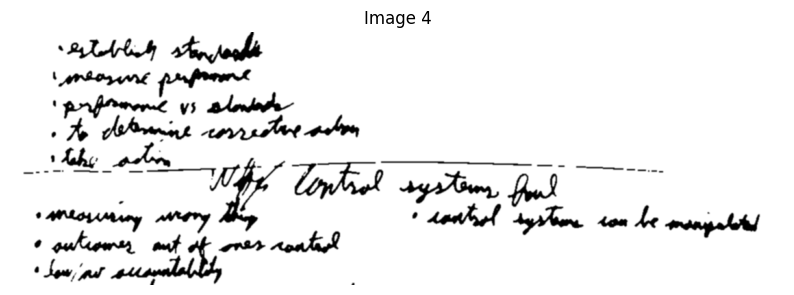

[B-L1-W1] e s t a b l i s h  85%  
[B-L1-W2] s t a n d a r d s  88%

[B-L2-W1] m e a s u r e  90%  
[B-L2-W2] p e r f o r m a n c e  92%

[B-L3-W1] p e r f o r m a n c e  85%  
[B-L3-W2] v s  80%  
[B-L3-W3] s t a n d a r d s  85%

[B-L4-W1] t o  95%  
[B-L4-W2] d e t e r m i n e  86%  
[B-L4-W3] c o r r e c t i v e  80%  
[B-L4-W4] a c t i o n  84%

[B-L5-W1] t a k e  83%  
[B-L5-W2] a c t i o n  85%

[T1-L1-W1] O p e n  90%  
[T1-L1-W2] C o n t r o l  88%  
[T1-L1-W3] s y s t e m s  82%  
[T1-L1-W4] f a i l  80%

[B-L6-W1] m e a s u r i n g  86%  
[B-L6-W2] e v e r y  90%  
[B-L6-W3] t h i n g  88%

[B-L7-W1] o u t c o m e s  85%  
[B-L7-W2] o u t  80%  
[B-L7-W3] o f  90%  
[B-L7-W4] o u r  78%  
[B-L7-W5] c o n t r o l  82%

[B-L8-W1] l o w e r i n g  80%  
[B-L8-W2] a c c o u n t a b i l i t y  75%

[B-L9-W1] c o n t r o l  85%  
[B-L9-W2] s y s t e m  82%  
[B-L9-W3] c a n  88%  
[B-L9-W4] b e  90%  
[B-L9-W5] m a n i p u l a t e d  80%


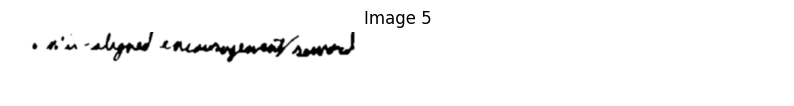

[No Text]


In [29]:
# Save and print all results

# Directory to save the split images
output_dir = "split_images"

# Clear the directory if it exists
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

responses = []
threads = []
num_threads = 5 

def readImage(responses, i, pic):
    converted_img = Image.fromarray(pic)
    
    # Save the image
    image_path = os.path.join(output_dir, f"image_{i+1}.webp")
    converted_img.save(image_path, 'WEBP', quality=15)
    
    #Get chatGPT translation
    import time
    time.sleep(.5*i)    # add pause incrementing pause for each call to not overwhelm the openai server
    print(f"Processing Image {i}")
    responses[i] = gpt.run_chatgpt(image_path)

responses = [None] * len(split_images)  # Initialize responses with size so it is thread safe
threads = []

# Start threads
for i, pic in enumerate(split_images):
    t = threading.Thread(target=readImage, args=(responses, i, pic))
    threads.append(t)
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

# Display each image and its response in the original order
for i, pic in enumerate(split_images):
    plt.figure(figsize=(10, 10))
    plt.imshow(pic)
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()
    print(responses[i])